***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet\Training_and_Analysis\6_Stanford_Cars
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "5" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  5
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


# Parameters

In [4]:
train_params = {"n_epochs" : 100,
                "batch_size": 16,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": 'adam',
                "loss_function": models.MarginLoss(),
               }

# Import Dataset : Stanford_Cars

In [5]:
training_dataset,  test_dataset, val_dataset, tree, info = datasets.Stanford_Cars(image_size=(64, 64), 
                                                                                  batch_size=train_params['batch_size'],
                                                                                  data_aug = 'mixup',
                                                                                  data_normalizing = None)

In [6]:
for x,y in training_dataset.take(1):
    image_shape = x.shape[1:]
    coarse_label_shape = y[0].shape[1:]
    medium_label_shape = y[1].shape[1:]
    fine_label_shape = y[2].shape[1:]

In [7]:
## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": info['Num_Coarse'],
                         "medium": info['Num_Medium'],
                         "fine": info['Num_Fine']})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

## Learning Rate Decay Scheduler

In [8]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

## Model Architecture

# Bottom up Approach

## Loss Function

In [9]:
Matrix_coarse_to_medium_OneHot = tf.constant(info['Matrix_coarse_to_medium'], dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(info['Matrix_medium_to_fine'], dtype=tf.float32)

In [10]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def consistency_check(y_pred_ancestor,y_pred_current,lookup_matrix,num_class_current):
    pred_max_ancestor = tf.argmax(y_pred_ancestor,axis=1)
    pred_max_current = tf.argmax(y_pred_current,axis=1)
    
    consistant_check = tf.gather(lookup_matrix, indices=pred_max_ancestor)*tf.one_hot(pred_max_current,num_class_current)
    
    return tf.reduce_sum(consistant_check,1)

def get_consistency(y_true_ancestor, y_pred, lookup_matrix):
    '''
    Get consistency based on 2 levels
    Provide ture levels for the level above, predictions for the current level and a look up metrix
    '''
    y_prob = tf.math.divide(y_pred,tf.reshape(tf.reduce_sum(y_pred,-1),(-1,1),name='reshape'),name='Probability')
    
    index_for_predictions = tf.cast(tf.math.argmax(y_true_ancestor,axis=1),dtype= 'int32')
    consistent_fine = tf.gather(lookup_matrix, indices=index_for_predictions) * y_prob
    Consistency_sum_array = tf.reduce_sum(consistent_fine, axis =1)
    
    return tf.abs(1-Consistency_sum_array)

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,
               number_of_classes_m, number_of_classes_f, C_Weight=0.2):
    
    con_m = consistency_check(y_pred_c,y_pred_m,Matrix_coarse_to_medium_OneHot,num_class_current=number_of_classes_m)
    con_m_not = tf.abs(con_m-1)
    
    con_f = consistency_check(y_pred_m,y_pred_f,Matrix_medium_to_fine_OneHot,num_class_current=number_of_classes_f)
    con_f_not = tf.abs(con_f-1)
    
    con_sum_m = get_consistency(y_true_c,y_pred_m,Matrix_coarse_to_medium_OneHot)
    con_sum_f = get_consistency(y_true_m,y_pred_f,Matrix_medium_to_fine_OneHot)
    
    medium_lvl_cosistency = con_sum_m * con_m_not
    fine_lvl_cosistency = con_sum_f * con_f_not    
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*((1-C_Weight)*(margin_loss(y_true_m, y_pred_m))+C_Weight*(medium_lvl_cosistency))
    ML_f = LW_F*((1-C_Weight)*(margin_loss(y_true_f, y_pred_f))+C_Weight*(fine_lvl_cosistency))
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Architecture

In [11]:
def get_compiled_model():
    input_shape = image_shape

    input_shape_yc = coarse_label_shape
    input_shape_ym = medium_label_shape
    input_shape_yf = fine_label_shape

    no_coarse_class = info['Num_Coarse']
    no_medium_class = info['Num_Medium']
    no_fine_class = info['Num_Fine']

    PCap_n_dims = 8

    SCap_f_dims = 16
    SCap_m_dims = 16
    SCap_c_dims = 16


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    # input [batch_size, 6, 6, 512], output [batch_size, 2304, 8]

    reshape = keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims), PCap_n_dims)
                                   , name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshape)

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(p_caps)

    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_f_dims, 
                        name="s_caps_medium")(s_caps_f)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(s_caps_m)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(
        inputs= [x_input, y_c, y_m, y_f],
        outputs= [pred_c, pred_m, pred_f],
        name='HD-CapsNet')
    
    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw'],
                             info['Num_Medium'],info['Num_Fine']))
    
    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
                 )
    return model

## Compile Model

In [12]:
model = get_compiled_model()

## log directory

In [13]:
directory = sysenv.log_dir('6_Stanford_Cars/HD_CapsNet/W_C_loss')

FOLDER CREATED =  ../../logs/6_Stanford_Cars/HD_CapsNet/W_C_loss


In [14]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 64, 64, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 64, 64, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.cast (TFOpLambda)           (None,)              0           ['tf.math.argmax_4[0][0]']       
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 1)            0           ['tf.math.reduce_sum_2[0][0]']   
                                                                                                  
 tf.math.argmax (TFOpLambda)    (None,)              0           ['prediction_coarse[0][0]']      
                                                                                                  
 tf.math.argmax_1 (TFOpLambda)  (None,)              0           ['prediction_medium[0][0]']      
                                                                                                  
 tf.math.argmax_5 (TFOpLambda)  (None,)              0           ['input_ym[0][0]']               
          

 da)                                                                                              
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None,)             0           ['tf.math.multiply[0][0]']       
 )                                                                                                
                                                                                                  
 tf.math.maximum_4 (TFOpLambda)  (None, 196)         0           ['tf.math.subtract_10[0][0]']    
                                                                                                  
 tf.math.subtract_12 (TFOpLambd  (None, 196)         0           ['input_yf[0][0]']               
 a)                                                                                               
                                                                                                  
 tf.math.m

                                                                                                  
 tf.math.multiply_4 (TFOpLambda  (None,)             0           ['tf.math.abs_2[0][0]',          
 )                                                                'tf.math.abs[0][0]']            
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 196)          0           ['tf.math.multiply_16[0][0]',    
                                                                  'tf.math.multiply_18[0][0]']    
                                                                                                  
 tf.math.abs_3 (TFOpLambda)     (None,)              0           ['tf.math.subtract_3[0][0]']     
                                                                                                  
 tf.math.abs_1 (TFOpLambda)     (None,)              0           ['tf.math.subtract_1[0][0]']     
          

## Data Augmentation

## Training Pipeline Alignment

In [15]:
#### Matching the pipeling with model inputs
def pipeline_multi_input_output(image, label):
    label_0 = label[0]
    label_1 = label[1]
    label_2 = label[2]
    return (image, label_0, label_1, label_2), (label_0, label_1, label_2)

training_dataset_match = training_dataset.map(pipeline_multi_input_output) ## Mixup dataset
val_dataset_match = val_dataset.map(pipeline_multi_input_output) ## Val Dataset

## Callback

In [16]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [17]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_dataset_match,
                        epochs = train_params["n_epochs"],
                        validation_data = val_dataset_match,
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
509/509 [==============================] - ETA: 0s - loss: 0.7466 - prediction_coarse_accuracy: 0.2133 - prediction_medium_accuracy: 0.0153 - prediction_fine_accuracy: 0.0161
  • Coarse Accuracy = 21.33% | Val_Accuracy = 26.32% | LossWeight = 0.42 
  • Medium Accuracy = 1.53% | Val_Accuracy = 2.64% | LossWeight = 0.36 
  • Fine   Accuracy = 1.61% | Val_Accuracy = 0.50% | LossWeight = 0.22 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.00498, saving model to ../../logs/6_Stanford_Cars/HD_CapsNet/W_C_loss\epoch-best.h5
509/509 [==============================] - 232s 382ms/step - loss: 0.7466 - prediction_coarse_accuracy: 0.2133 - prediction_medium_accuracy: 0.0153 - prediction_fine_accuracy: 0.0161 - val_loss: 0.5786 - val_prediction_coarse_accuracy: 0.2632 - val_prediction_medium_accuracy: 0.0264 - val_prediction_fine_accuracy: 0.0050 - lr: 0.0010
Epoch 2/100
509/509 [==============================] - ETA: 0s - loss: 0.5459 - prediction_coarse_accuracy: 0.25

509/509 [==============================] - 216s 392ms/step - loss: 0.4085 - prediction_coarse_accuracy: 0.5352 - prediction_medium_accuracy: 0.1723 - prediction_fine_accuracy: 0.6539 - val_loss: 0.4777 - val_prediction_coarse_accuracy: 0.4308 - val_prediction_medium_accuracy: 0.1025 - val_prediction_fine_accuracy: 0.0838 - lr: 0.0010
Epoch 10/100
509/509 [==============================] - ETA: 0s - loss: 0.3762 - prediction_coarse_accuracy: 0.6017 - prediction_medium_accuracy: 0.2596 - prediction_fine_accuracy: 0.7195
  • Coarse Accuracy = 60.17% | Val_Accuracy = 42.31% | LossWeight = 0.39 
  • Medium Accuracy = 25.96% | Val_Accuracy = 11.54% | LossWeight = 0.49 
  • Fine   Accuracy = 71.95% | Val_Accuracy = 9.03% | LossWeight = 0.11 

Epoch 10: val_prediction_fine_accuracy improved from 0.08383 to 0.09030, saving model to ../../logs/6_Stanford_Cars/HD_CapsNet/W_C_loss\epoch-best.h5
509/509 [==============================] - 216s 392ms/step - loss: 0.3762 - prediction_coarse_accuracy: 

Epoch 19/100
509/509 [==============================] - ETA: 0s - loss: 0.1091 - prediction_coarse_accuracy: 0.9592 - prediction_medium_accuracy: 0.9508 - prediction_fine_accuracy: 0.9595
  • Coarse Accuracy = 95.92% | Val_Accuracy = 45.25% | LossWeight = 0.45 
  • Medium Accuracy = 95.08% | Val_Accuracy = 15.30% | LossWeight = 0.37 
  • Fine   Accuracy = 95.95% | Val_Accuracy = 9.35% | LossWeight = 0.18 

Epoch 19: val_prediction_fine_accuracy did not improve from 0.10373
509/509 [==============================] - 215s 389ms/step - loss: 0.1091 - prediction_coarse_accuracy: 0.9592 - prediction_medium_accuracy: 0.9508 - prediction_fine_accuracy: 0.9595 - val_loss: 0.5181 - val_prediction_coarse_accuracy: 0.4525 - val_prediction_medium_accuracy: 0.1530 - val_prediction_fine_accuracy: 0.0935 - lr: 6.3025e-04
Epoch 20/100
509/509 [==============================] - ETA: 0s - loss: 0.1065 - prediction_coarse_accuracy: 0.9621 - prediction_medium_accuracy: 0.9571 - prediction_fine_accuracy: 0

509/509 [==============================] - 216s 392ms/step - loss: 0.0934 - prediction_coarse_accuracy: 0.9681 - prediction_medium_accuracy: 0.9683 - prediction_fine_accuracy: 0.9684 - val_loss: 0.5574 - val_prediction_coarse_accuracy: 0.4410 - val_prediction_medium_accuracy: 0.1515 - val_prediction_fine_accuracy: 0.0943 - lr: 3.9721e-04
Epoch 29/100
509/509 [==============================] - ETA: 0s - loss: 0.0930 - prediction_coarse_accuracy: 0.9698 - prediction_medium_accuracy: 0.9683 - prediction_fine_accuracy: 0.9692
  • Coarse Accuracy = 96.98% | Val_Accuracy = 44.93% | LossWeight = 0.47 
  • Medium Accuracy = 96.83% | Val_Accuracy = 15.82% | LossWeight = 0.33 
  • Fine   Accuracy = 96.92% | Val_Accuracy = 9.38% | LossWeight = 0.20 

Epoch 29: val_prediction_fine_accuracy did not improve from 0.10373
509/509 [==============================] - 215s 390ms/step - loss: 0.0930 - prediction_coarse_accuracy: 0.9698 - prediction_medium_accuracy: 0.9683 - prediction_fine_accuracy: 0.9692

509/509 [==============================] - ETA: 0s - loss: 0.0870 - prediction_coarse_accuracy: 0.9764 - prediction_medium_accuracy: 0.9747 - prediction_fine_accuracy: 0.9736
  • Coarse Accuracy = 97.64% | Val_Accuracy = 46.17% | LossWeight = 0.46 
  • Medium Accuracy = 97.47% | Val_Accuracy = 15.55% | LossWeight = 0.33 
  • Fine   Accuracy = 97.36% | Val_Accuracy = 8.98% | LossWeight = 0.21 

Epoch 38: val_prediction_fine_accuracy did not improve from 0.10373
509/509 [==============================] - 215s 389ms/step - loss: 0.0870 - prediction_coarse_accuracy: 0.9764 - prediction_medium_accuracy: 0.9747 - prediction_fine_accuracy: 0.9736 - val_loss: 0.5516 - val_prediction_coarse_accuracy: 0.4617 - val_prediction_medium_accuracy: 0.1555 - val_prediction_fine_accuracy: 0.0898 - lr: 2.3783e-04
Epoch 39/100
509/509 [==============================] - ETA: 0s - loss: 0.0842 - prediction_coarse_accuracy: 0.9746 - prediction_medium_accuracy: 0.9750 - prediction_fine_accuracy: 0.9722
  • Coa

509/509 [==============================] - 217s 393ms/step - loss: 0.0876 - prediction_coarse_accuracy: 0.9731 - prediction_medium_accuracy: 0.9727 - prediction_fine_accuracy: 0.9714 - val_loss: 0.5627 - val_prediction_coarse_accuracy: 0.4423 - val_prediction_medium_accuracy: 0.1525 - val_prediction_fine_accuracy: 0.0908 - lr: 1.4989e-04
Epoch 48/100
509/509 [==============================] - ETA: 0s - loss: 0.0834 - prediction_coarse_accuracy: 0.9738 - prediction_medium_accuracy: 0.9740 - prediction_fine_accuracy: 0.9732
  • Coarse Accuracy = 97.38% | Val_Accuracy = 45.30% | LossWeight = 0.48 
  • Medium Accuracy = 97.40% | Val_Accuracy = 15.57% | LossWeight = 0.32 
  • Fine   Accuracy = 97.32% | Val_Accuracy = 9.18% | LossWeight = 0.20 

Epoch 48: val_prediction_fine_accuracy did not improve from 0.10373
509/509 [==============================] - 215s 390ms/step - loss: 0.0834 - prediction_coarse_accuracy: 0.9738 - prediction_medium_accuracy: 0.9740 - prediction_fine_accuracy: 0.9732

509/509 [==============================] - ETA: 0s - loss: 0.0853 - prediction_coarse_accuracy: 0.9790 - prediction_medium_accuracy: 0.9788 - prediction_fine_accuracy: 0.9765
  • Coarse Accuracy = 97.90% | Val_Accuracy = 45.82% | LossWeight = 0.47 
  • Medium Accuracy = 97.88% | Val_Accuracy = 15.52% | LossWeight = 0.32 
  • Fine   Accuracy = 97.65% | Val_Accuracy = 9.53% | LossWeight = 0.21 

Epoch 57: val_prediction_fine_accuracy did not improve from 0.10373
509/509 [==============================] - 216s 392ms/step - loss: 0.0853 - prediction_coarse_accuracy: 0.9790 - prediction_medium_accuracy: 0.9788 - prediction_fine_accuracy: 0.9765 - val_loss: 0.5627 - val_prediction_coarse_accuracy: 0.4582 - val_prediction_medium_accuracy: 0.1552 - val_prediction_fine_accuracy: 0.0953 - lr: 8.9745e-05
Epoch 58/100
509/509 [==============================] - ETA: 0s - loss: 0.0838 - prediction_coarse_accuracy: 0.9756 - prediction_medium_accuracy: 0.9741 - prediction_fine_accuracy: 0.9750
  • Coa

509/509 [==============================] - 215s 390ms/step - loss: 0.0839 - prediction_coarse_accuracy: 0.9779 - prediction_medium_accuracy: 0.9757 - prediction_fine_accuracy: 0.9773 - val_loss: 0.5479 - val_prediction_coarse_accuracy: 0.4674 - val_prediction_medium_accuracy: 0.1590 - val_prediction_fine_accuracy: 0.0968 - lr: 5.6562e-05
Epoch 67/100
509/509 [==============================] - ETA: 0s - loss: 0.0809 - prediction_coarse_accuracy: 0.9792 - prediction_medium_accuracy: 0.9772 - prediction_fine_accuracy: 0.9792
  • Coarse Accuracy = 97.92% | Val_Accuracy = 45.27% | LossWeight = 0.46 
  • Medium Accuracy = 97.72% | Val_Accuracy = 15.50% | LossWeight = 0.35 
  • Fine   Accuracy = 97.92% | Val_Accuracy = 9.60% | LossWeight = 0.19 

Epoch 67: val_prediction_fine_accuracy did not improve from 0.10373
509/509 [==============================] - 215s 390ms/step - loss: 0.0809 - prediction_coarse_accuracy: 0.9792 - prediction_medium_accuracy: 0.9772 - prediction_fine_accuracy: 0.9792

509/509 [==============================] - ETA: 0s - loss: 0.0834 - prediction_coarse_accuracy: 0.9797 - prediction_medium_accuracy: 0.9762 - prediction_fine_accuracy: 0.9769
  • Coarse Accuracy = 97.97% | Val_Accuracy = 46.37% | LossWeight = 0.44 
  • Medium Accuracy = 97.62% | Val_Accuracy = 15.40% | LossWeight = 0.35 
  • Fine   Accuracy = 97.69% | Val_Accuracy = 9.38% | LossWeight = 0.21 

Epoch 76: val_prediction_fine_accuracy did not improve from 0.10373
509/509 [==============================] - 216s 391ms/step - loss: 0.0834 - prediction_coarse_accuracy: 0.9797 - prediction_medium_accuracy: 0.9762 - prediction_fine_accuracy: 0.9769 - val_loss: 0.5512 - val_prediction_coarse_accuracy: 0.4637 - val_prediction_medium_accuracy: 0.1540 - val_prediction_fine_accuracy: 0.0938 - lr: 3.3866e-05
Epoch 77/100
509/509 [==============================] - ETA: 0s - loss: 0.0801 - prediction_coarse_accuracy: 0.9752 - prediction_medium_accuracy: 0.9786 - prediction_fine_accuracy: 0.9772
  • Coa

509/509 [==============================] - 215s 390ms/step - loss: 0.0845 - prediction_coarse_accuracy: 0.9764 - prediction_medium_accuracy: 0.9767 - prediction_fine_accuracy: 0.9756 - val_loss: 0.5519 - val_prediction_coarse_accuracy: 0.4647 - val_prediction_medium_accuracy: 0.1557 - val_prediction_fine_accuracy: 0.0955 - lr: 2.1344e-05
Epoch 86/100
509/509 [==============================] - ETA: 0s - loss: 0.0838 - prediction_coarse_accuracy: 0.9795 - prediction_medium_accuracy: 0.9777 - prediction_fine_accuracy: 0.9788
  • Coarse Accuracy = 97.95% | Val_Accuracy = 46.34% | LossWeight = 0.46 
  • Medium Accuracy = 97.77% | Val_Accuracy = 15.45% | LossWeight = 0.34 
  • Fine   Accuracy = 97.88% | Val_Accuracy = 9.48% | LossWeight = 0.20 

Epoch 86: val_prediction_fine_accuracy did not improve from 0.10373
509/509 [==============================] - 215s 391ms/step - loss: 0.0838 - prediction_coarse_accuracy: 0.9795 - prediction_medium_accuracy: 0.9777 - prediction_fine_accuracy: 0.9788

509/509 [==============================] - ETA: 0s - loss: 0.0827 - prediction_coarse_accuracy: 0.9789 - prediction_medium_accuracy: 0.9770 - prediction_fine_accuracy: 0.9764
  • Coarse Accuracy = 97.89% | Val_Accuracy = 46.02% | LossWeight = 0.46 
  • Medium Accuracy = 97.70% | Val_Accuracy = 15.45% | LossWeight = 0.34 
  • Fine   Accuracy = 97.64% | Val_Accuracy = 9.55% | LossWeight = 0.21 

Epoch 95: val_prediction_fine_accuracy did not improve from 0.10373
509/509 [==============================] - 215s 389ms/step - loss: 0.0827 - prediction_coarse_accuracy: 0.9789 - prediction_medium_accuracy: 0.9770 - prediction_fine_accuracy: 0.9764 - val_loss: 0.5514 - val_prediction_coarse_accuracy: 0.4602 - val_prediction_medium_accuracy: 0.1545 - val_prediction_fine_accuracy: 0.0955 - lr: 1.2779e-05
Epoch 96/100
509/509 [==============================] - ETA: 0s - loss: 0.0794 - prediction_coarse_accuracy: 0.9780 - prediction_medium_accuracy: 0.9765 - prediction_fine_accuracy: 0.9759
  • Coa

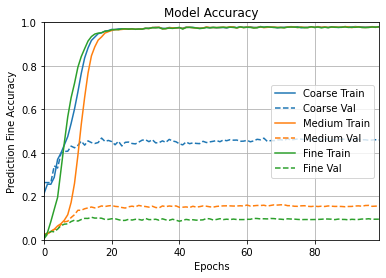

In [18]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

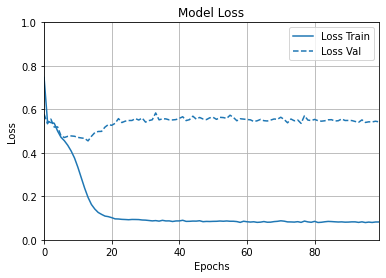

In [19]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

## Model Analysis

In [20]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

In [21]:
results = final_model.evaluate(test_dataset)
for n in range(len(results)):
    print(str(n+1)+'.',final_model.metrics_names[n], '==>', results[n])
model_predictions = final_model.predict(test_dataset)

252/252 [==============================] - 31s 113ms/step - loss: 0.5774 - prediction_coarse_loss: 0.5147 - prediction_medium_loss: 0.6255 - prediction_fine_loss: 0.6692 - prediction_coarse_accuracy: 0.4588 - prediction_medium_accuracy: 0.1554 - prediction_fine_accuracy: 0.0948
1. loss ==> 0.5773887634277344
2. prediction_coarse_loss ==> 0.5147067904472351
3. prediction_medium_loss ==> 0.6255289316177368
4. prediction_fine_loss ==> 0.6692487001419067
5. prediction_coarse_accuracy ==> 0.45884108543395996
6. prediction_medium_accuracy ==> 0.15543396770954132
7. prediction_fine_accuracy ==> 0.09475255012512207


In [22]:
def predict_from_pipeline(model, dataset):
    y_pred = []
    y_true = []
    image = []
    for x, y in dataset:
        batch_pred = model.predict(x)
        for i in range(len(batch_pred)):
            if i >= len(y_pred):
                y_pred.append(None)
                y_true.append(None)
                image.append(None)
            if y_pred[i] is None:
                y_pred[i] = batch_pred[i]
                y_true[i] = list(y[i].numpy())
                image[i] = list(x[i].numpy())
            else:
                y_pred[i] = np.concatenate([y_pred[i], batch_pred[i]])
                y_true[i] = y_true[i] + list(y[i].numpy())
                image[i] = image[i] + list(x[i].numpy())
    return y_true, y_pred, image

In [ ]:
predictions = []
predictions.append(predict_from_pipeline(final_model, test_dataset))

In [ ]:
dataset= {'x_test':predictions[0][2][0], 
          'y_test_coarse':predictions[0][0][0], 
          'y_test_medium':predictions[0][0][1], 
          'y_test_fine':predictions[0][0][2]}

In [ ]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0][1][0],predictions[0][1][1],predictions[0][1][2]]

In [ ]:
metrics.lvl_wise_metric(true_label,pred_label)

In [ ]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,pred_label,tree)
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )